In [1]:
import torch
from tqdm import tqdm
import torchvision.transforms.functional as F

device = torch.device("cuda")
x_size, y_size = 64, 64
guidance_scale = 7.0
num_inference_steps = 50
_prompt = "An image of a squirrel in Picasso style"
repo_id = "runwayml/stable-diffusion-v1-5"

In [2]:
from diffusers import UNet2DConditionModel, DDIMScheduler, AutoencoderKL

unet = UNet2DConditionModel.from_pretrained(repo_id, subfolder="unet", use_safetensors=True)
unet.to(device)

vae = AutoencoderKL.from_pretrained(repo_id, subfolder="vae", use_safetensors=True)
vae.to(device)

scheduler = DDIMScheduler.from_pretrained(repo_id, subfolder="scheduler")
scheduler.set_timesteps(num_inference_steps)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import CLIPTextModel, CLIPTokenizer
tokenizer = CLIPTokenizer.from_pretrained(
    repo_id, subfolder="tokenizer"
)
text_encoder = CLIPTextModel.from_pretrained(
    repo_id, subfolder="text_encoder"
)
text_encoder.to(device)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [4]:
prompt = ["", _prompt]
text_inputs = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
).to(device)
text_input_ids = text_inputs.input_ids

prompt_embeds = text_encoder(text_input_ids.squeeze(1))
prompt_embeds = prompt_embeds[0].to(device)

In [5]:
noise = torch.randn(
    (1, unet.config.in_channels, x_size, y_size)
).to(device)
with torch.no_grad():
    progress_bar = tqdm(scheduler.timesteps)
    for t in progress_bar:
        noise_input = torch.cat([noise] * 2)

        model_output = unet(
            noise_input,
            t,
            encoder_hidden_states=prompt_embeds,
        )[0]
        noise_pred_uncond, noise_pred_text = model_output.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (
            noise_pred_text - noise_pred_uncond
        )

        noise = scheduler.step(noise_pred, t, noise)[0]

100%|███████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.45it/s]


In [10]:
def decode_noise(noise):
    with torch.no_grad():
        return vae.decode(noise / vae.config.scaling_factor, return_dict=False)[0]

def denormalize(images):
    """
    Denormalize an image array to [0,1].
    """
    return (images / 2 + 0.5).clamp(0, 1)

def numpy_to_pil(image):
    return F.to_pil_image((image * 255).round().astype("uint8"))

def noise_to_pil(noise):
    return numpy_to_pil(denormalize(decode_noise(noise)).cpu().permute(0, 2, 3, 1)[0].numpy())

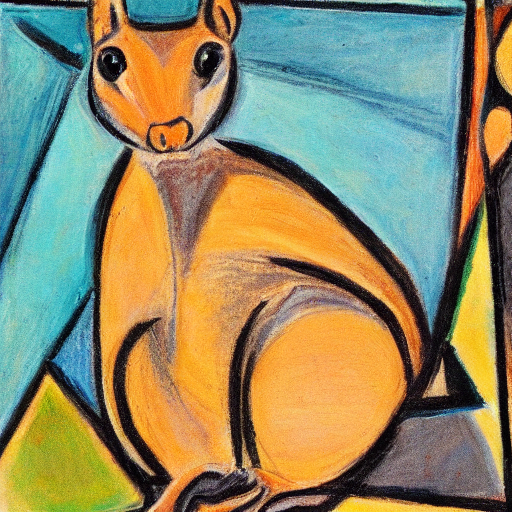

In [11]:
im = noise_to_pil(noise)
im

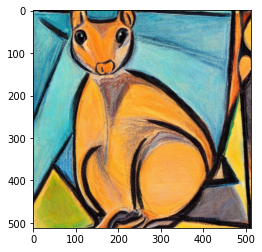

In [16]:
import matplotlib.pyplot as plt
plt.imshow(im)

In [12]:
im.save("squirrel.png")

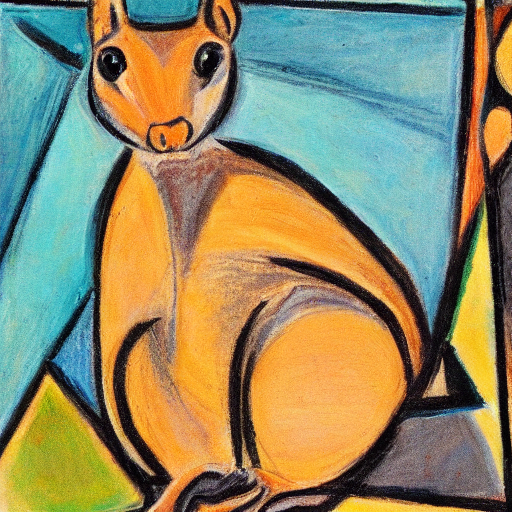

In [14]:
from PIL import Image

Image.open("squirrel.png")